In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [2]:
import torch
import torchvision
print(torch.__version__)

2.5.1+cu118


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import os
from PIL import Image

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import torch

In [5]:
data_dir = os.path.join(path, "eyepacs-aptos-messidor-diabetic-retinopathy")
num_epochs = 20
batch_size = 64
learning_rate = 1e-4
print("Path to dataset files:", path)

Path to dataset files: C:\Users\chittes\.cache\kagglehub\datasets\ascanipek\eyepacs-aptos-messidor-diabetic-retinopathy\versions\4


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Dataset root
data_dir = r"C:\Users\chittes\Downloads\DR_Dataset_extracted\augmented_resized_V2"

# Transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)

])

val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Classes
print("Classes:", train_dataset.classes)

Classes: ['Class 1', 'Class 2']


In [8]:
import torch
import torch.nn as nn
from torchvision.ops import DeformConv2d

class DeformableBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DeformableBlock, self).__init__()
        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size=3, padding=1)
        self.deform_conv = DeformConv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        offset = self.offset_conv(x)
        x = self.deform_conv(x, offset)
        x = self.bn(x)
        return self.relu(x)

class DRDeformableCNN(nn.Module):
    def __init__(self):
        super(DRDeformableCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # Normal conv
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.layer2 = DeformableBlock(32, 32)

        self.layer3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer4 = DeformableBlock(64, 64)

        self.layer5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer6 = DeformableBlock(128, 128)

        self.layer7 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.layer8 = DeformableBlock(256, 256)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)  # conv
        x = self.layer2(x)  # deform

        x = self.layer3(x)  # conv
        x = self.layer4(x)  # deform

        x = self.layer5(x)  # conv
        x = self.layer6(x)  # deform

        x = self.layer7(x)  # conv
        x = self.layer8(x)  # deform

        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DRDeformableCNN().to(device)

# Use BCELoss (NOT BCEWithLogitsLoss)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Shape: (B, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=running_loss/total, acc=correct/total)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = (outputs >= 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(val_loss=val_loss/val_total, val_acc=val_correct/val_total)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        if scheduler:
            scheduler.step()

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        print(f"[{epoch+1:02}/{num_epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [11]:
train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs, device, train_loader, val_loader
)

[01/20] Train Loss: 0.5038, Acc: 0.7415 | Val Loss: 0.4344, Acc: 0.7946


[02/20] Train Loss: 0.4203, Acc: 0.8011 | Val Loss: 0.3888, Acc: 0.8235


[03/20] Train Loss: 0.3842, Acc: 0.8250 | Val Loss: 0.3564, Acc: 0.8437


[04/20] Train Loss: 0.3602, Acc: 0.8381 | Val Loss: 0.3522, Acc: 0.8445


[05/20] Train Loss: 0.3468, Acc: 0.8465 | Val Loss: 0.3470, Acc: 0.8453


[06/20] Train Loss: 0.3189, Acc: 0.8610 | Val Loss: 0.3232, Acc: 0.8612


[07/20] Train Loss: 0.3078, Acc: 0.8661 | Val Loss: 0.3205, Acc: 0.8631


[08/20] Train Loss: 0.2991, Acc: 0.8708 | Val Loss: 0.3340, Acc: 0.8590


[09/20] Train Loss: 0.2907, Acc: 0.8750 | Val Loss: 0.3247, Acc: 0.8614


[10/20] Train Loss: 0.2839, Acc: 0.8784 | Val Loss: 0.3159, Acc: 0.8653


[11/20] Train Loss: 0.2606, Acc: 0.8904 | Val Loss: 0.3111, Acc: 0.8685


[12/20] Train Loss: 0.2513, Acc: 0.8940 | Val Loss: 0.3119, Acc: 0.8681


[13/20] Train Loss: 0.2430, Acc: 0.8986 | Val Loss: 0.3153, Acc: 0.8679


[14/20] Train Loss: 0.2357, Acc: 0.9017 | Val Loss: 0.3217, Acc: 0.8612


[15/20] Train Loss: 0.2279, Acc: 0.9053 | Val Loss: 0.3322, Acc: 0.8660


[16/20] Train Loss: 0.2088, Acc: 0.9140 | Val Loss: 0.3311, Acc: 0.8674


[17/20] Train Loss: 0.2034, Acc: 0.9179 | Val Loss: 0.3378, Acc: 0.8620


[18/20] Train Loss: 0.1973, Acc: 0.9206 | Val Loss: 0.3358, Acc: 0.8641


[19/20] Train Loss: 0.1922, Acc: 0.9225 | Val Loss: 0.3381, Acc: 0.8660


[20/20] Train Loss: 0.1866, Acc: 0.9253 | Val Loss: 0.3464, Acc: 0.8635


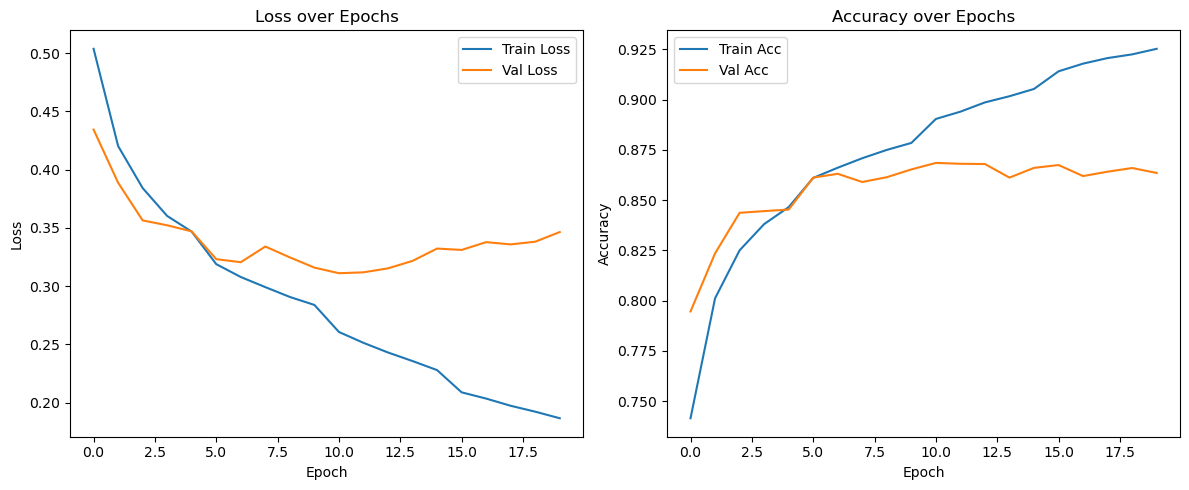

In [12]:
epochs = range(num_epochs)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
import torch
import numpy as np

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if total == 0:
        print("❌ Test set is empty.")
        return None

    # Metrics
    all_preds = np.array(all_preds).astype(int)
    all_labels = np.array(all_labels).astype(int)

    TP = ((all_preds == 1) & (all_labels == 1)).sum()
    TN = ((all_preds == 0) & (all_labels == 0)).sum()
    FP = ((all_preds == 1) & (all_labels == 0)).sum()
    FN = ((all_preds == 0) & (all_labels == 1)).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0
    avg_loss = total_loss / total

    print("\n📊 Test Evaluation Metrics")
    print(f"✅ Accuracy  : {accuracy * 100:.2f}%")
    print(f"📉 Loss      : {avg_loss:.4f}")
    print(f"📊 Precision : {precision:.4f}")
    print(f"📊 Recall    : {recall:.4f}")
    print(f"📊 F1 Score  : {f1:.4f}")

    return {
        "accuracy": accuracy,
        "loss": avg_loss,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
evaluate_model(model, test_loader, criterion, device)


📊 Test Evaluation Metrics
✅ Accuracy  : 86.49%
📉 Loss      : 0.3386
📊 Precision : 0.9142
📊 Recall    : 0.8137
📊 F1 Score  : 0.8610


{'accuracy': 0.8648686712203366,
 'loss': 0.3386156584307389,
 'precision': 0.914180252230083,
 'recall': 0.8136892539356605,
 'f1_score': 0.8610125298761497}